In [1]:
import casadi as cs
import casclik as cc
from urdf2casadi import converter, numpy_geom, casadi_geom
import time

# Plotting
from matplotlib import pyplot as plt
%matplotlib notebook
import common_plots

# Graphs in article
This notebook generates figures from the article. Specifically, the transformation matrix vs dual quaternion figures. The code is not well commented, and the results are not discussed other than in the article.

# Quaternion and Dual quaternion functions
Let's convert some casadi_geom expressions into casadi functions so they work with MX variables

In [2]:
# Quaternions
quat1 = cs.SX.sym("quat1",4)
quat2 = cs.SX.sym("quat2",4)
quaternion_product = cs.Function("quatprod",[quat1,quat2],[casadi_geom.quaternion_product(quat1,quat2)])
quaternion_conj = cs.Function("quatconj", [quat1], [casadi_geom.quaternion_conj(quat1)])
hamilton_operator_plus = cs.Function(
    "hamilton_operator_plus",
    [quat1],
    [cs.vertcat(cs.horzcat(quat1[3], -quat1[2], quat1[1], quat1[0]),
                cs.horzcat(quat1[2], quat1[3], -quat1[0], quat1[1]),
                cs.horzcat(-quat1[1], quat1[0], quat1[3], quat1[2]),
                cs.horzcat(-quat1[0], -quat1[1], -quat1[2], quat1[3]))])
hamilton_operator_minus = cs.Function(
    "hamilton_operator_minus",
    [quat1],
    [cs.vertcat(cs.horzcat(quat1[3], quat1[2], -quat1[1], quat1[0]),
               cs.horzcat(-quat1[2], quat1[3], quat1[0], quat1[1]),
               cs.horzcat(quat1[1], -quat1[0], quat1[3], quat1[2]),
               cs.horzcat(-quat1[0], -quat1[1], -quat1[2], quat1[3]))])

# Dual quaternions
quat1 = cs.SX.sym("quat1",8) # Dual quaternions
quat2 = cs.SX.sym("quat2",8)
dual_quaternion_product = cs.Function("dualquatprod", 
                                      [quat1,quat2], 
                                      [casadi_geom.dual_quaternion_product(quat1,quat2)])
dual_quaternion_conj = cs.Function("dualquatconj", 
                                   [quat1], 
                                   [casadi_geom.dual_quaternion_conj(quat1)])
dual_quaternion_dualnorm = cs.Function("dualquatdualnorm",
                                       [quat1], 
                                       [casadi_geom.dual_quaternion_norm2(quat1)[0],casadi_geom.dual_quaternion_norm2(quat1)[1]])
dual_quaternion_inv = cs.Function("dualquatinv", 
                                  [quat1], 
                                  [casadi_geom.dual_quaternion_inv(quat1)])
dual_quaternion_to_transformation_matrix = cs.Function("dualquat2transfmat",
                                                       [quat1],
                                                       [casadi_geom.dual_quaternion_to_transformation_matrix(quat1)])
dual_quaternion_to_pos = cs.Function("dualquat2pos",
                                    [quat1],
                                    [casadi_geom.dual_quaternion_to_pos(quat1)])
dual_hamilton_operator_plus = cs.Function(
    "dH_plus",
    [quat1],
    [cs.vertcat(
        cs.horzcat(quat1[3], -quat1[2], quat1[1], quat1[0], 0, 0, 0, 0),
        cs.horzcat(quat1[2], quat1[3], -quat1[0], quat1[1], 0, 0, 0, 0),
        cs.horzcat(-quat1[1], quat1[0], quat1[3], quat1[2], 0, 0, 0, 0),
        cs.horzcat(-quat1[0], -quat1[1], -quat1[2], quat1[3], 0, 0, 0, 0),
        cs.horzcat(quat1[7], -quat1[6], quat1[5], quat1[4], quat1[3], -quat1[2], quat1[1], quat1[0]),
        cs.horzcat(quat1[6], quat1[7], -quat1[4], quat1[5], quat1[2], quat1[3], -quat1[0], quat1[1]),
        cs.horzcat(-quat1[5], quat1[4], quat1[7], quat1[6], -quat1[1], quat1[0], quat1[3], quat1[2]),
        cs.horzcat(-quat1[4], -quat1[5], -quat1[6], quat1[7], -quat1[0], -quat1[1], -quat1[2], quat1[3])
    )]
)
dual_hamilton_operator_minus = cs.Function(
    "dH_minus",
    [quat1],
    [cs.vertcat(
        cs.horzcat(quat1[3], quat1[2], -quat1[1], quat1[0], 0, 0, 0, 0),
        cs.horzcat(-quat1[2], quat1[3], quat1[0], quat1[1], 0, 0, 0, 0),
        cs.horzcat(quat1[1], -quat1[0], quat1[3], quat1[2], 0, 0, 0, 0),
        cs.horzcat(-quat1[0], -quat1[1], -quat1[2], quat1[3], 0, 0, 0, 0),
        cs.horzcat(quat1[7], quat1[6], -quat1[5], quat1[4], quat1[3], quat1[2], -quat1[1], quat1[0]),
        cs.horzcat(-quat1[6], quat1[7], quat1[4], quat1[5], -quat1[2], quat1[3], quat1[0], quat1[1]),
        cs.horzcat(quat1[5], -quat1[4], quat1[7], quat1[6], quat1[1], -quat1[0], quat1[3], quat1[2]),
        cs.horzcat(-quat1[4], -quat1[5], -quat1[6], quat1[7], -quat1[0], -quat1[1], -quat1[2], quat1[3])
    )]
)
# Roll pitch yaw Euler angles
xyz=cs.SX.sym("xyz",3)
rpy=cs.SX.sym("rpy",3)
dual_quaternion_rpy = cs.Function("dualquatrpy",
                                  [rpy],
                                 [casadi_geom.dual_quaternion_rpy(rpy)])
dual_quaternion_xyz = cs.Function("dualquatxyz",
                                 [xyz],
                                 [casadi_geom.dual_quaternion_translation(xyz)])

# Axis angle
axis = cs.SX.sym("axis",3)
ang = cs.SX.sym("ang")
dual_quaternion_axis_translation = cs.Function("dualquataxistransl",
                                              [axis, ang],
                                              [casadi_geom.dual_quaternion_axis_translation(axis,ang)])
dual_quaternion_axis_rotation = cs.Function("dualquataxisrot",
                                           [axis, ang],
                                           [casadi_geom.dual_quaternion_axis_rotation(axis,ang)])

# UR5 - Dual Quaternion or Transformation Matrix representation
Transformation matrices are a 16 element representation of the transformation between frames, with 12 unique elements. This represents the transformation as a rotation matrix and a displacement vector. Usually in robotics one follows the convention of first translating then rotating to match frames. Another representation is dual quaternions, they use two quaternions to represent the rotation and displacement of transformations and use 8 elements to describe the same transformation. In this example we will try to move from the HOME position to a desired frame, then later from a random frame to a random frame.

In [3]:
t = cs.MX.sym("t")
q = cs.MX.sym("q",6) # six actuated joints
dq = cs.MX.sym("dq",6)
UR5_home = [0.0, -cs.np.pi/2, 0.0, -cs.np.pi/2, 0.0, 0.0]

## Get forward kinematics
The converter creates a kinematic chain from a specific root link to an end link. Running `check_urdf` on the file, we find that the UR5 contains the links:
```
root Link: world has 1 child(ren)
    child(1):  base_link
        child(1):  base
        child(2):  shoulder_link
            child(1):  upper_arm_link
                child(1):  forearm_link
                    child(1):  wrist_1_link
                        child(1):  wrist_2_link
                            child(1):  wrist_3_link
                                child(1):  ee_link
                                child(2):  tool0
```
Let's set up the forward kinematics:

In [4]:
urdf_path = "./urdf/ur5.urdf"
links = ["world", 
         "base_link", 
         "base", 
         "shoulder_link", 
         "upper_arm_link", 
         "forearm_link", 
         "wrist_1_link", 
         "wrist_2_link", 
         "wrist_3_link", 
         "tool0"]
fk_dict = converter.from_file(root="base_link", tip="tool0", filename=urdf_path)

In [5]:
print(str(fk_dict["joint_names"]))

['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint', 'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']


In [6]:
# Setup the function for the dual quaternion of the forward kinematics:
Q_fk = fk_dict["dual_quaternion_fk"]
# Setup the function for the transformation matrix of the forward kinematics:
T_fk = fk_dict["T_fk"]

In [7]:
# Test transformation matrix:
Q0 = Q_fk(UR5_home)
T0 = numpy_geom.dual_quaternion_to_transformation_matrix(Q0.toarray())
print("Distance to UR5_pome pos with dual quaternions: "+str(cs.norm_2(T0[:3,3])))

# Test transformation matrix:
T0 = T_fk(UR5_home)
print("Distance to UR5Home pos with transformation matrices: "+str(cs.norm_2(T0[:3,3])))

Distance to UR5_pome pos with dual quaternions: 1.0192
Distance to UR5Home pos with transformation matrices: 1.0192


## UR5 Limits
To achieve reasonable simulations, we impose some realistic limits on the robot. We grab the joint limits from the URDF and choose a reasonable max speed.

In [8]:
# Check the joint limits from the URDF:
q_max = cs.np.array(fk_dict["upper"])
q_min = cs.np.array(fk_dict["lower"])
print("q_min ",str(q_min))
print("q_max ",str(q_max))

# Define a reasonable max joint speed
max_speed = cs.np.pi/5 # rad/s
print("Max speed: ", max_speed)
dt = 0.008

('q_min ', '[-6.28318531 -6.28318531 -3.14159265 -6.28318531 -6.28318531 -6.28318531]')
('q_max ', '[ 6.28318531  6.28318531  3.14159265  6.28318531  6.28318531  6.28318531]')
('Max speed: ', 0.6283185307179586)


In [9]:
# Define the basic system limits
# Uphold the joint constraints
joint_limits_cnstr = cc.SetConstraint(
    label="Joint_Limits",
    expression = q,
    set_min = q_min,
    set_max = q_max)

# Listify the joint limits constraints for pseudoinverse, starting with the lowest
joint_limits_cnstr_list = []
for i in range(q.size()[0]):
    joint_limits_cnstr_list.append(
    cc.SetConstraint(label="limit_q_"+str(i),
                     expression=q[i],
                     set_min = q_min[i],
                     set_max = q_max[i],
                    priority = i))

# Let's have some speed limit
joint_speed_limits_cnstr = cc.VelocitySetConstraint(
    label="Joint_speed_limits",
    expression = q,
    set_min = -cs.vertcat([max_speed]*q.size()[0]),
    set_max = cs.vertcat([max_speed]*q.size()[0]))

## Move from home to frame
In this section we will move from the HOME position to a desired frame. There are multiple methods of representing a constraint that could achieve this, and we will investigate two for each representation.

In [10]:
# Desired frame
rpy = [
    5.*(cs.np.pi/180.0),#5.*(cs.np.pi/180.0),
    0.*(cs.np.pi/180.0),#0.5*cs.np.pi,
    0.*(cs.np.pi/180.0)
]
xyz = [
    0.5,
    0.0,
    0.5
]
# As a dual quaternion
Q_des = numpy_geom.dual_quaternion_revolute(xyz, rpy, # cartesian and euler angles
                                            [1,0,0],0.0) # If we wanted an extra axis-angle rotation afterwards
# As a transformation matrix

T_des = cs.np.eye(4) 
T_des[:3,:3] = numpy_geom.rotation_rpy(*rpy)
T_des[:3,3] = xyz # Some desired position 

### Constraint representations - Dual quaternion

In [11]:
# Deviation from identity
Q_id = numpy_geom.dual_quaternion_revolute([0.,0.,0.],[0.,0.,0.],[1.,0.,0.],0.0)
Q_dist1 = dual_quaternion_product(Q_fk(q),dual_quaternion_conj(Q_des)) - Q_id
Q_dist1_cnstr = cc.EqualityConstraint(
    label="Q_dist1_cnstr",
    expression=Q_dist1,
    constraint_type="soft",
    gain = 10.0,
    priority=301
)
Q_dist1_cnstr.eval = cs.Function("Q_dist1",[t,q],[cs.norm_2(Q_dist1)])

Hm = dual_hamilton_operator_minus(Q_des)
Cconj = cs.diag([-1,-1,-1,1,-1,-1,-1,1])
Q_dist2 = cs.mtimes(Hm, cs.mtimes(Cconj, Q_des-Q_fk(q)))
Q_dist2_cnstr = cc.EqualityConstraint(
    label="Q_dist2_cnstr",
    expression=Q_dist2,
    constraint_type="soft",
    gain=10.0,
    priority=301
)
Q_dist2_cnstr.eval = cs.Function("Q_dist2",[t,q], [cs.norm_2(Q_dist2)])

### Constraint representations - Transformation matrix

In [12]:
# Deviation from identity
T_dist1_cnstr = cc.EqualityConstraint(
    label="T_dist1",
    expression=cs.norm_fro(cs.mtimes(cs.inv(T_des),T_fk(q))-cs.np.eye(4)),
    gain=10.0,
    constraint_type="soft",
    priority=301
)
T_dist1_cnstr.eval = cs.Function("f_T_dist1", [t,q],[T_dist1_cnstr.expression])

# Frobenius norm of rotation deviation from identity, Position deviation
T_dist2_cnstr = cc.EqualityConstraint(
    label="T_dist2",
    expression = cs.vertcat(T_fk(q)[:3,3]-T_des[:3,3], 
                            cs.norm_fro(cs.mtimes(cs.inv(T_des[:3,:3]),T_fk(q)[:3,:3]) - cs.np.eye(3))),
    gain = 10.0,
    constraint_type = "soft",
    priority = 300
)
T_dist2_cnstr.eval = cs.Function("f_T_dist2", [t,q], [cs.norm_2(T_dist2_cnstr.expression)])

# Three point strategy
T_dist3_cnstr = cc.EqualityConstraint(
    label="T_dist3",
    expression = cs.vertcat(T_fk(q)[0, :3].T + T_fk(q)[:3,3] - T_des[0, :3] - T_des[:3,3],
                            T_fk(q)[1, :3].T + T_fk(q)[:3,3] - T_des[1, :3] - T_des[:3,3],
                            T_fk(q)[2, :3].T + T_fk(q)[:3,3] - T_des[2, :3] - T_des[:3,3]),
    gain=10.0,
    constraint_type= "soft",
    priority=300
)
T_dist3_cnstr.eval = cs.Function("f_T_dist3", [t,q], [cs.norm_2(T_dist3_cnstr.expression)])

### Compiling the controllers for all constraint situations

In [13]:
# Let's test all the available controllers
controller_classes = {
    "qp":cc.ReactiveQPController, 
    "nlp":cc.ReactiveNLPController, 
    "pinv":cc.PseudoInverseController,
    "mpc":cc.ModelPredictiveController
}
controllers = {}
for key in controller_classes.keys():
    controllers[key] = {}

In [14]:
cnstr_situations={
    "Q_dist1":Q_dist1_cnstr, 
    "Q_dist2":Q_dist2_cnstr,
    "T_dist1":T_dist1_cnstr,
    "T_dist2":T_dist2_cnstr,
    "T_dist3":T_dist3_cnstr}
print cnstr_situations.keys()

['T_dist2', 'Q_dist2', 'Q_dist1', 'T_dist1', 'T_dist3']


In [15]:
# Compile all the controllers for each situation
for cnstr in cnstr_situations.keys():
    print("Compiling constraint: "+str(cnstr))
    for key in controllers.keys():
        if key == "pinv":
            #constraints = joint_limits_cnstr_list + [cnstr_situations[cnstr]]
            #constraints = [joint_limits_cnstr, cnstr_situations[cnstr]]
            constraints = [cnstr_situations[cnstr]]
        else:
            #constraints = [joint_limits_cnstr, joint_speed_limits_cnstr, cnstr_situations[cnstr]]
            constraints = [joint_limits_cnstr, cnstr_situations[cnstr]]
            #constraints = [cnstr_situations[cnstr]]
        skill_spec = cc.SkillSpecification(
            label=cnstr+"_skill",
            time_var=t,
            robot_var=q,
            constraints=constraints
        )
        t0 = time.time()
        if key == "mpc":
            controllers[key][cnstr] = controller_classes[key](skill_spec=skill_spec,
                                                              horizon_length=10, timestep=dt)
        else:
            controllers[key][cnstr] = controller_classes[key](skill_spec=skill_spec)
        if key == "pinv":
            controllers[key][cnstr].options["multidim_sets"] = True
            controllers[key][cnstr].options["pinv_method"] = "damped"
            controllers[key][cnstr].options["damping_factor"] = 1e-26
        controllers[key][cnstr].setup_problem_functions()
        controllers[key][cnstr].setup_solver()
        print("\t-"+str(key)+", compile time: "+str(time.time()-t0))

Compiling constraint: T_dist2
	-qp, compile time: 0.376299858093
	-nlp, compile time: 1.10620594025
	-pinv, compile time: 0.728753089905
	-mpc, compile time: 18.8923389912
Compiling constraint: Q_dist2
	-qp, compile time: 0.464783906937
	-nlp, compile time: 1.75674200058
	-pinv, compile time: 0.885903120041
	-mpc, compile time: 23.5716860294
Compiling constraint: Q_dist1
	-qp, compile time: 0.644954919815
	-nlp, compile time: 3.17797899246
	-pinv, compile time: 1.26287794113
	-mpc, compile time: 31.3702230453
Compiling constraint: T_dist1
	-qp, compile time: 0.302688121796
	-nlp, compile time: 1.02917385101
	-pinv, compile time: 0.349567174911
	-mpc, compile time: 21.4482560158
Compiling constraint: T_dist3
	-qp, compile time: 0.59046792984
	-nlp, compile time: 1.62333083153
	-pinv, compile time: 1.20321798325
	-mpc, compile time: 26.383852005


In [16]:
timesteps = 1000
# Run all simulations
for cntr_key in controllers.keys():
    print("Simulating controller: "+str(cntr_key))
    for cnstr_key in cnstr_situations.keys():
        print("\t-"+str(cnstr_key))
        print("\t\tSetting up initial value problem")
        controllers[cntr_key][cnstr_key].setup_initial_problem_solver()
        print("\t\tSolving initial value problem")
        slack_res = controllers[cntr_key][cnstr_key].solve_initial_problem(0,UR5_home)[-1]
        t0 = time.time()
        # Simulate it!
        t_sim = cs.np.array([dt*i for i in range(timesteps+1)])
        t_run_sim = cs.np.array([dt*i for i in range(timesteps)])
        # Robot
        q_sim = cs.np.zeros((len(t_sim),q.shape[0]))
        q_sim[0,:] = UR5_home
        dq_sim = cs.np.zeros((len(t_sim),dq.shape[0]))
        # Cartesian position
        p_sim = cs.np.zeros((len(t_sim), 3))
        p_sim[0,:] = T_fk(UR5_home)[:3,3].toarray()[:,0]
        # Rotation
        R_sim = cs.np.zeros((len(t_sim), 3, 3))
        R_sim[0,:,:] = T_fk(UR5_home)[:3,:3].toarray()
        # Error in constraint
        e_sim = cs.np.zeros(len(t_sim))
        e_sim[0] = cnstr_situations[cnstr_key].eval(t_sim[0],q_sim[0,:])
        # Loop
        for i in range(len(t_sim) - 1):
            t_run0 = time.time()
            res = controllers[cntr_key][cnstr_key].solve(t_sim[i],q_sim[i,:],warmstart_slack_var=slack_res)
            t_run_sim[i] = time.time() - t_run0
            dq_sim[i,:] = res[0].toarray()[:,0]
            if res[-1] is not None:
                slack_res = res[-1].toarray()[:,0]
            for idx, dqi in enumerate(dq_sim[i,:]):
                dq_sim[i,idx] = max(min(dqi,max_speed),-max_speed)
            q_sim[i+1,:] = q_sim[i,:] + dq_sim[i,:]*dt
            p_sim[i+1,:] = T_fk(q_sim[i+1,:])[:3,3].toarray()[:,0]
            R_sim[i+1,:,:] = T_fk(q_sim[i+1,:])[:3,:3].toarray()
            e_sim[i+1] = cnstr_situations[cnstr_key].eval(t_sim[i],q_sim[i+1,:])
        controllers[cntr_key][str(cnstr_key)+"_res"] = {
            "t_sim":t_sim,
            "dq_sim": dq_sim,
            "q_sim": q_sim,
            "p_sim": p_sim,
            "R_sim": R_sim,
            "e_sim": e_sim,
            "t_run_sim": t_run_sim
        }
        print("\t\tRuntime: "+str(time.time()-t0))

Simulating controller: qp
	-T_dist2
		Setting up initial value problem
		Solving initial value problem
		Runtime: 0.506732940674
	-Q_dist2
		Setting up initial value problem
		Solving initial value problem
		Runtime: 0.492563009262
	-Q_dist1
		Setting up initial value problem
		Solving initial value problem
		Runtime: 0.486197948456
	-T_dist1
		Setting up initial value problem
		Solving initial value problem
		Runtime: 0.438336133957
	-T_dist3
		Setting up initial value problem
		Solving initial value problem
		Runtime: 0.518247127533
Simulating controller: nlp
	-T_dist2
		Setting up initial value problem
		Solving initial value problem

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
***********************************************

### Error plots

Text(0.5,1,'Q\\_dist1')

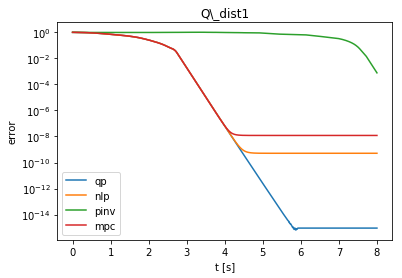

In [17]:
fig, ax = plt.subplots()
for name in controllers.keys():
    ax.plot(controllers[name]["Q_dist1_res"]["t_sim"],
            controllers[name]["Q_dist1_res"]["e_sim"],
            label=name)
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("error")
ax.set_yscale("log")
ax.set_title("Q\_dist1")

<IPython.core.display.Javascript object>


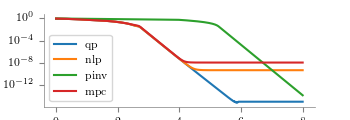

In [29]:
import nice_plotting
nice_plotting.latexify(fig_width=3.5,fig_height=1.2)
fig, ax = plt.subplots()
for name in controllers.keys():
    ax.plot(controllers[name]["Q_dist2_res"]["t_sim"],
            controllers[name]["Q_dist2_res"]["e_sim"],
            label=name)
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("${e}_Q$")
ax.set_yscale("log")
nice_plotting.format_axes(ax)
plt.savefig("e_Q_error.pdf",bbox_inches="tight")

Text(0.5,1,'T\\_dist1')

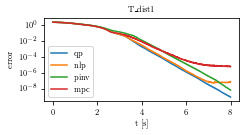

In [19]:
fig, ax = plt.subplots()
for name in controllers.keys():
    ax.plot(controllers[name]["T_dist1_res"]["t_sim"],
            controllers[name]["T_dist1_res"]["e_sim"],
            label=name)
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("error")
ax.set_yscale("log")
ax.set_title("T\_dist1")

<IPython.core.display.Javascript object>


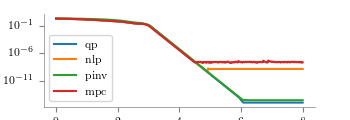

In [31]:
nice_plotting.latexify(fig_width=3.5,fig_height=1.2)
fig, ax = plt.subplots()
for name in controllers.keys():
    ax.plot(controllers[name]["T_dist2_res"]["t_sim"],
            controllers[name]["T_dist2_res"]["e_sim"],
            label=name)
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("${e}_T$")
ax.set_yscale("log")
nice_plotting.format_axes(ax)
plt.savefig("e_T_error.pdf",bbox_inches="tight")

Text(0.5,1,'T\\_dist3')

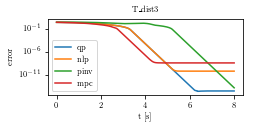

In [21]:
fig, ax = plt.subplots()
for name in controllers.keys():
    ax.plot(controllers[name]["T_dist3_res"]["t_sim"],
            controllers[name]["T_dist3_res"]["e_sim"],
            label=name)
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("error")
ax.set_yscale("log")
ax.set_title("T\_dist3")

### Seeing the paths
The black line is the end-effector position, the red line is 0.1 in x direction from the end-effector center, green is y and blue is z.

<IPython.core.display.Javascript object>


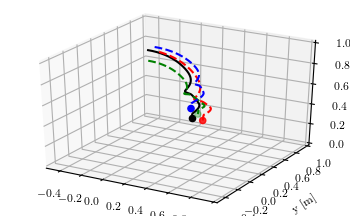

In [22]:
%matplotlib notebook
nice_plotting.latexify(fig_width=3.5)
ax = common_plots.frame_3d(controllers["qp"]["Q_dist2_res"],T_des=T_des)
#ax.set_title("QP($e_Q$)")
ax.set_xlim([-0.5, 1.])
ax.set_ylim([-0.5, 1.])
ax.set_zlim([0., 1])
ax.set_zlabel("z [m]")
#nice_plotting.format_axes(ax)
plt.savefig("e_Q_traj.pdf",bbox_inches="tight",pad_inches=0.25)

<IPython.core.display.Javascript object>


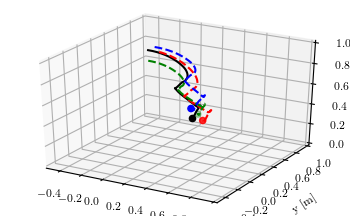

In [23]:
nice_plotting.latexify(fig_width=3.5)
ax = common_plots.frame_3d(controllers["qp"]["T_dist2_res"],T_des=T_des)
#ax.set_title("QP($e_Q$)")
ax.set_xlim([-0.5, 1.])
ax.set_ylim([-0.5, 1.])
ax.set_zlim([0., 1])
ax.set_zlabel("z [m]")
#nice_plotting.format_axes(ax)
plt.savefig("e_T_traj.pdf",bbox_inches="tight", pad_inches=0.25)

<IPython.core.display.Javascript object>


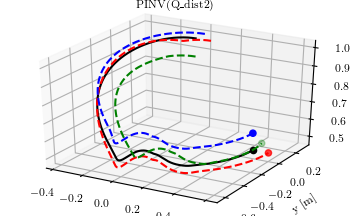

Text(0.5,0.92,'PINV(Q\\_dist2)')

In [24]:
ax = common_plots.frame_3d(controllers["pinv"]["Q_dist2_res"],T_des=T_des)
ax.set_title("PINV(Q\_dist2)")

<IPython.core.display.Javascript object>


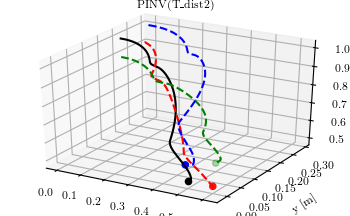

Text(0.5,0.92,'PINV(T\\_dist2)')

In [25]:
ax = common_plots.frame_3d(controllers["pinv"]["T_dist2_res"],T_des=T_des)
ax.set_title("PINV(T\_dist2)")

In [26]:
def ms_format(t):
    return "{:.2f} ms".format(1000.0*t)    
for cnstr_key in cnstr_situations.keys():
    print("Constraint: "+str(cnstr_key))
    for cntrl_key in controllers.keys():
        print("\tController: "+str(cntrl_key))
        print("\t\tInitial: "+ms_format(controllers[cntrl_key][cnstr_key+"_res"]["t_run_sim"][0]))
        print("\t\tAverage: "+ms_format(cs.np.mean(controllers[cntrl_key][cnstr_key+"_res"]["t_run_sim"])))

Constraint: T_dist2
	Controller: qp
		Initial: 0.60 ms
		Average: 0.25 ms
	Controller: nlp
		Initial: 4.15 ms
		Average: 2.94 ms
	Controller: pinv
		Initial: 0.06 ms
		Average: 0.04 ms
	Controller: mpc
		Initial: 17.45 ms
		Average: 159.76 ms
Constraint: Q_dist2
	Controller: qp
		Initial: 0.68 ms
		Average: 0.24 ms
	Controller: nlp
		Initial: 3.58 ms
		Average: 2.93 ms
	Controller: pinv
		Initial: 0.07 ms
		Average: 0.05 ms
	Controller: mpc
		Initial: 21.13 ms
		Average: 17.94 ms
Constraint: Q_dist1
	Controller: qp
		Initial: 0.58 ms
		Average: 0.24 ms
	Controller: nlp
		Initial: 4.50 ms
		Average: 3.09 ms
	Controller: pinv
		Initial: 0.07 ms
		Average: 0.05 ms
	Controller: mpc
		Initial: 26.52 ms
		Average: 19.81 ms
Constraint: T_dist1
	Controller: qp
		Initial: 0.42 ms
		Average: 0.20 ms
	Controller: nlp
		Initial: 3.50 ms
		Average: 3.04 ms
	Controller: pinv
		Initial: 0.05 ms
		Average: 0.04 ms
	Controller: mpc
		Initial: 46.51 ms
		Average: 79.39 ms
Constraint: T_dist3
	Controller

In [27]:
def ms_format(t):
    return"{:.2f} ms".format(1000.0*t)
cntrllrs_tab = ["pinv","qp","nlp","mpc"]
tab_str = "& PINV & QP & NLPC & MPC\\\\ \n\midrule\n"
tab_str += "Initial ($\\bm{e}_Q$)"
for cntrl_key in cntrllrs_tab:
    tab_str += "& "+ms_format(controllers[cntrl_key]["Q_dist2_res"]["t_run_sim"][0])
tab_str += "\\\\\n"
tab_str += "Average ($\\bm{e}_Q$)"
for cntrl_key in cntrllrs_tab:
    tab_str += "& "+ms_format(cs.np.mean(controllers[cntrl_key]["Q_dist2_res"]["t_run_sim"]))
tab_str += "\\\\\n"
tab_str += "Initial ($\\bm{e}_T$)"
for cntrl_key in cntrllrs_tab:
    tab_str += "& "+ms_format(controllers[cntrl_key]["T_dist2_res"]["t_run_sim"][0])
tab_str += "\\\\\n"
tab_str += "Average ($\\bm{e}_T$)"
for cntrl_key in cntrllrs_tab:
    tab_str += "& "+ms_format(cs.np.mean(controllers[cntrl_key]["T_dist2_res"]["t_run_sim"]))
print(tab_str)

& PINV & QP & NLPC & MPC\\ 
\midrule
Initial ($\bm{e}_Q$)& 0.07 ms& 0.68 ms& 3.58 ms& 21.13 ms\\
Average ($\bm{e}_Q$)& 0.05 ms& 0.24 ms& 2.93 ms& 17.94 ms\\
Initial ($\bm{e}_T$)& 0.06 ms& 0.60 ms& 4.15 ms& 17.45 ms\\
Average ($\bm{e}_T$)& 0.04 ms& 0.25 ms& 2.94 ms& 159.76 ms
